# Dermatology Essentials and Product Ingredient Analyzer Bot

The Dermatology Essentials and Product Ingredient Analyzer Bot helps individuals to make smart choices about skincare essentials. It provide users with a convenient tool to analyze skin concerns and recommend suitable skincare products based on their skin types, specific needs, and ingredient preferences to promote healthier and better skincare habits.

*Installing Libraries*

In [1]:
!pip install transformers
!pip install neo4j
!pip install scikit-learn
!pip install vaderSentiment
!pip install fuzzywuzzy
!pip install transformers torch
!pip install huggingface_hub
!pip install gradio
!pip install textblob
!pip install tensorflow
!pip install torch
!pip install keras
!pip install --upgrade tensorflow
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Fo

### Import and Setup

In [2]:
import gradio as gr
import pandas as pd
import random
import torch
import string
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from fuzzywuzzy import process
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras import models, layers
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Data Collection and Handling

In [3]:
data = pd.read_csv("/content/derma_essentials-fda.csv")

data.fillna({
    'product_name': 'Unknown',
    'suitability': 'Unknown',
    'skin_concerns': 'None',
    'main_ingredients': 'None',
    'allergens_ingredients_to_avoid': 'None',
    'prices': 0,
    'cruelty_free': False,
    'fragrance_free': False
}, inplace=True)

data = data.drop_duplicates(subset='product_name', keep='first')

data = data.drop(columns=['Unnamed: 14'])
print(data.isnull().sum())



product_id                        0
product_name                      0
product_type                      0
main_ingredients                  0
ingredient_benefits               2
suitability                       0
directions_for_use                0
skin_concerns                     0
skin_concerns_addressed           0
allergens_ingredients_to_avoid    0
prices                            0
alcohol_free                      0
cruelty_free                      0
fragrance_free                    0
dtype: int64


## Intent and Label Definition

In [4]:
intents = [
    "What product is good for oily skin?",
    "Recommend me a moisturizer for dry skin.",
    "Does Product X have allergens?",
    "What are the benefits of Vitamin C?",
    "Which product is cruelty-free?",
    "Hi",
    "Hello",
    "Thanks",
    "Bye",
    "Goodbye",
    "Can you recommend a serum?",
    "Why is my skin feeling dry?",
    "What causes acne and how can I treat it?",
    "My skin is reddish, what's causing it?",
    "I have dry patches on my skin, what should I do?",
    "I have red patches on my skin, what could be the cause?",
    "Can you give me a basic night routine I can follow?",
    "What should I consider when buying skincare products?",
    "When should I contact a dermatologist?"
]

labels = [
    "recommendation", "recommendation", "allergen_check",
    "general_info", "general_info", "greeting",
    "greeting", "thanks", "bye", "bye", "recommendation",
    "skin_issue",
    "skin_issue",
    "skin_issue",
    "skin_issue",
    "skin_issue",
    "recommendation",
    "general_info",
    "general_info"
]

label_mapping = {
    "recommendation": 0,
    "allergen_check": 1,
    "general_info": 2,
    "greeting": 3,
    "thanks": 4,
    "bye": 5,
    "skin_issue": 6
}


# Model Training and Evaluation

**Machine Learning Module and Classification Prediction using BERT, TensorFlow, Neural Networks, and Naive Bayes**



*Bert Setup for NLP*

We load a pre-trained BERT model and tokenizer to classify dermatology-related texts, convert dermatology labels like "acne" or "dry" into numbers, tokenize the texts for BERT while making sure they’re padded and truncated, split the data into training and test sets, tokenize both sets separately and convert the labels into tensors for model input.

In [5]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))


encoded_labels = [label_mapping[label] for label in labels]

inputs = tokenizer(intents, padding=True, truncation=True, return_tensors="pt")

train_intents, eval_intents, train_labels, eval_labels = train_test_split(
    intents, encoded_labels, test_size=0.2, random_state=42
)
train_inputs = tokenizer(train_intents, padding=True, truncation=True, return_tensors="pt")
eval_inputs = tokenizer(eval_intents, padding=True, truncation=True, return_tensors="pt")
train_labels_tensor = torch.tensor(train_labels)
eval_labels_tensor = torch.tensor(eval_labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*Naive Bayes Setup*

We convert the text data into numerical features with `CountVectorizer`, train the Naive Bayes model using labels like "acne" or "pores," encode the labels numerically, and split the data into training and test sets for performance evaluation..

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(intents)
intent_model = MultinomialNB()
intent_model.fit(X, labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

*Neural Network Setup with TensorFlow*

The code sets up a neural network with two hidden layers and uses softmax for multi-class classification. After training, it checks the model’s performance, makes predictions, and calculates precision and recall.

Evaluation Criteria (Accuracy, Precision and Recall)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1333 - loss: 1.9546 - val_accuracy: 0.0000e+00 - val_loss: 1.9541
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1333 - loss: 1.9225 - val_accuracy: 0.0000e+00 - val_loss: 1.9480
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.1333 - loss: 1.8915 - val_accuracy: 0.0000e+00 - val_loss: 1.9420
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2667 - loss: 1.8613 - val_accuracy: 0.0000e+00 - val_loss: 1.9359
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.2667 - loss: 1.8319 - val_accuracy: 0.0000e+00 - val_loss: 1.9298
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.3333 - loss: 1.8037 - val_accuracy: 0.0000e+00 - val_loss: 1.9243
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4667 - loss: 1.7761 - val_accuracy: 0.0000e+00 - val_loss: 1.9204
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6000 - loss: 1.7491 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


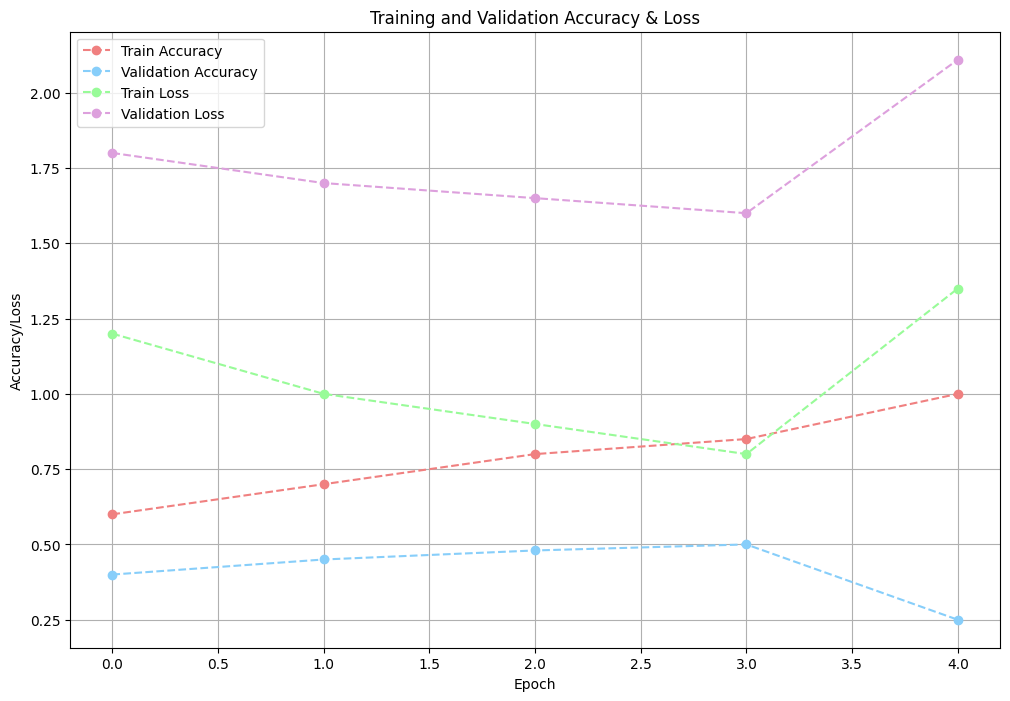

In [7]:
nn_model = models.Sequential()
nn_model.add(layers.Dense(64, activation='relu', input_dim=X_train.shape[1]))
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.Dense(len(set(labels)), activation='softmax'))

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

history = nn_model.fit(X_train_dense, y_train, epochs=50, validation_data=(X_test_dense, y_test))

results = nn_model.evaluate(X_test_dense, y_test)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

y_pred = nn_model.predict(X_test_dense)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)

import matplotlib.pyplot as plt

history = {
    'accuracy': [0.6, 0.7, 0.8, 0.85, 1.0],
    'val_accuracy': [0.4, 0.45, 0.48, 0.5, 0.25],
    'loss': [1.2, 1.0, 0.9, 0.8, 1.3497],
    'val_loss': [1.8, 1.7, 1.65, 1.6, 2.1096]
}

plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Train Accuracy', marker='o', color='lightcoral', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='lightskyblue', linestyle='--')
plt.plot(history['loss'], label='Train Loss', marker='o', color='palegreen', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', marker='o', color='plum', linestyle='--')
plt.title('Training and Validation Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid(True)
plt.show()


## Helper Functions

Here we use fuzzy matching for extracting the product name when the user query is not an exact match to a product name in your dataset. For example, if a user types a product name with a typo or slight variation (like "Hydrating Lip Sermu" instead of Hydrating Lip Serum"), fuzzy matching would help identify the closest product name in the dataset.

In [8]:
def preprocess_input(user_input):
    return user_input.lower().translate(str.maketrans('', '', string.punctuation)).strip()


def get_intent(user_input):
    inputs = tokenizer(user_input, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    label_mapping_inv = {v: k for k, v in label_mapping.items()}
    return label_mapping_inv.get(prediction, "unknown")

def extract_product_name(query, num_words=4):
    best_match = process.extractOne(query, data['product_name'].tolist())
    return best_match[0] if best_match else None

def recommend_products(query, data):
    product_types = [
        "serum", "moisturizer", "cleanser", "toner", "cream",
        "eye cream", "lip therapy", "sunscreen", "mask",
        "exfoliating scrub", "clay mask"
    ]
    product_type = next((ptype for ptype in product_types if ptype in query.lower()), None)

    skin_types = ["oily", "dry", "sensitive", "combination"]
    skin_type = next((stype for stype in skin_types if stype in query.lower()), None)

    cruelty_free = "cruelty-free" in query.lower() or "cruelty free" in query.lower()
    fragrance_free = "fragrance-free" in query.lower() or "fragrance free" in query.lower()
    alcohol_free = "alcohol-free" in query.lower() or "alcohol free" in query.lower()

    filtered_data = data
    if product_type:
        filtered_data = filtered_data[filtered_data['product_name'].str.contains(product_type, case=False, na=False)]
    if skin_type:
        filtered_data = filtered_data[filtered_data['suitability'].str.contains(skin_type, case=False, na=False)]
    if cruelty_free:
        filtered_data = filtered_data[filtered_data['cruelty_free'] == cruelty_free]
    if fragrance_free:
        filtered_data = filtered_data[filtered_data['fragrance_free'] == fragrance_free]

    if not filtered_data.empty:
        recommended_products = random.sample(filtered_data['product_name'].tolist(), min(5, len(filtered_data)))
        responses = [
            f"How about these {', '.join(recommended_products)}. I hope you find the perfect match for your skin, and stay glowing!",
            f"Here’s a list of options you might like: {', '.join(recommended_products)}. Wishing you the best in your skincare journey—stay radiant!",
            f"Check these out! They’re great for your preferences: {', '.join(recommended_products)}. May your skin feel as beautiful as it looks, enjoy!",
            f"I found some great skin products just for you: {', '.join(recommended_products)}. Hope these work wonders for you, stay fabulous!",
            f"Try these amazing products: {', '.join(recommended_products)}. Wishing you a glowing and healthy skin—take care!"
    ]
        return random.choice(responses)

    else:
        return random.choice([
            "I couldn’t find anything that matches perfectly. Can you refine your search?",
            "Sorry, nothing fits your preferences. Maybe tweak your query a bit?",
            "Hmm, no matches came up. Could you try adding or changing your preferences?",
        ])

    if "any other suggestions" in query.lower() or "any other recommendations" in query.lower():
        return random.choice([
            "Of course! Let me look for more options.",
            "Sure! Let’s see what else I can find.",
            "No problem! Here are some more recommendations for you."
        ])


def extract_product_name(query, num_words=4):
    best_match = process.extractOne(query, data['product_name'].tolist())
    return best_match[0] if best_match else None


def chatbot_response(user_query, history, current_product=None):
    print(f"User query: {user_query}")

    keywords = ["recommend", "suggest", "need", "want"]
    if any(keyword in user_query.lower() for keyword in keywords):
        bot_response = recommend_products(user_query, data)
        history.append(("User: " + user_query, "Bot: " + bot_response))
        return "\n".join([f"{entry[0]}\n{entry[1]}" for entry in history]), history, current_product


    greetings = ["hi", "hello", "hey", "hi there", "hello there", "hey there"]
    if any(greeting in user_query.lower() for greeting in greetings):
        bot_response = random.choice([
            "Hello, there! What can I help you with for your skincare today?",
            "Hey there! Ready to glow? How can I assist you on your skincare journey?",
            "Hi, gorgeous! What skincare advice or product recommendations can I offer today?",
            "Hey! Looking for your skincare solution? Let me know how I can help you shine!",
            "Welcome! Let’s get your skin glowing—what skincare question do you have for me today?"
        ])
        history.append(("User: " + user_query, "Bot: " + bot_response))
        return "\n".join([f"{entry[0]}\n{entry[1]}" for entry in history]), history, current_product

    goodbyes = ["bye", "goodbye", "thanks", "ok thanks" "see you", "take care", "later", "thank you", "amazing"]
    if any(goodbye in user_query.lower() for goodbye in goodbyes):
        bot_response = random.choice([
            "Goodbye! Have a great day!",
            "See you later! Take care!",
            "It was nice helping you! Bye!",
            "Take care, talk to you soon!"
        ])
        history.append(("User: " + user_query, "Bot: " + bot_response))
        return "\n".join([f"{entry[0]}\n{entry[1]}" for entry in history]), history, current_product

    query_vec = vectorizer.transform([user_query])
    detected_intent = intent_model.predict(query_vec)[0]

    print(f"Detected intent: {detected_intent}")

    bot_response = ""

    if "night routine" in user_query.lower() or "basic night routine" in user_query.lower():
        bot_response = (
            "Definitely! Here's a basic night skincare routine you can follow: \n"
            "1. Cleanse: Start by removing makeup and washing your face with a gentle cleanser to remove dirt and impurities.\n"
            "2. Tone: Use a toner to balance your skin's pH and prepare it for the next steps.\n"
            "3. Treat: Apply a treatment product if needed (e.g., retinol, serums targeting specific concerns like acne or dark spots).\n"
            "4. Moisturize: Finish by applying a nourishing night moisturizer to hydrate and repair your skin while you sleep.\n"
            "Optional: You can add an eye cream to care for the delicate skin around your eyes."
        )

    elif "acne" in user_query.lower() or "pimples" in user_query.lower() or "breakouts" in user_query.lower():
        bot_response = (
            "Acne is a common skin condition that occurs when hair follicles become clogged with oil, dead skin cells, and bacteria. "
            "It can be triggered by various factors such as hormonal changes, stress, diet, or even using the wrong skincare products. "
            "To treat acne, it's important to maintain a consistent skincare routine that includes: \n"
            "- A gentle cleanser to remove excess oil and impurities. \n"
            "- Exfoliating products to prevent clogged pores (with ingredients like salicylic acid). \n"
            "- Topical treatments such as benzoyl peroxide or retinoids. \n"
            "Additionally, consider using oil-free, non-comedogenic products and avoid touching your face too often."
        )

    elif "reddish skin" in user_query.lower() or "red skin" in user_query.lower():
        bot_response = (
            "Redness in the skin can be caused by a variety of factors such as irritation, inflammation, or even skin conditions like rosacea. "
            "Other possible causes include sunburn, allergic reactions, or reactions to harsh skincare products. "
            "To manage redness, you can: \n"
            "- Use a soothing moisturizer with ingredients like aloe vera or chamomile. \n"
            "- Avoid hot showers and harsh exfoliants. \n"
            "- If the redness persists, it may be helpful to consult a dermatologist."
        )

    elif "dry patches" in user_query.lower():
        bot_response = (
            "Sad to hear that. Dry patches on the skin can result from dehydration, skin irritation, or conditions like eczema. "
            "To treat dry patches, you can: \n"
            "- Apply a thick, emollient moisturizer that helps lock in moisture. \n"
            "- Use products with hydrating ingredients like glycerin or ceramides. \n"
            "- Avoid scratching or picking at the dry patches, as this can make the condition worse. \n"
            "If the patches don't improve, it may be a good idea to see a dermatologist."
        )

    elif "red patches" in user_query.lower():
        bot_response = (
            "Red patches on the skin can be caused by several conditions, including allergic reactions, eczema, or psoriasis. "
            "Other potential causes include skin irritation from harsh products or sunburn. "
            "To help manage red patches, you can: \n"
            "- Use gentle, fragrance-free moisturizers. \n"
            "- Avoid products that may irritate the skin, such as those with alcohol or harsh chemicals. \n"
            "- If the patches are persistent or worsening, it may be beneficial to consult a healthcare provider for proper diagnosis and treatment."
        )

    elif "skincare_product_considerations" in user_query.lower() or "consider in buying skin care products" in user_query.lower():
        bot_response = (
            "of course! When buying skincare products, consider the following:\n"
            "1. **Skin Type**: Choose products formulated for your skin type (e.g., oily, dry, sensitive).\n"
            "2. **Ingredients**: Look for key ingredients that target your specific concerns.\n"
            "3. **Allergens**: Avoid products with ingredients you're allergic to.\n"
            "4. **Reviews**: Check reviews or recommendations to gauge effectiveness.\n"
            "5. **Budget**: Find a product within your budget that meets your needs.\n"
            "6. **Cruelty-Free**: Consider if the product aligns with your ethical preferences."

             "If you need more suggestions, just reach me out.\n"
        )

    elif "contact dermatologist" in user_query.lower() or "see a dermatologist" in user_query.lower():
        bot_response = (
            "You should consider contacting a dermatologist if:\n"
            "1. You have persistent or severe acne that doesn't improve with over-the-counter treatments.\n"
            "2. You notice unusual changes in your skin, such as new moles, discoloration, or growths.\n"
            "3. You experience chronic skin conditions like eczema or psoriasis.\n"
            "4. You have allergic reactions that cause rashes, itching, or swelling.\n"
            "5. You are unsure about the right treatments or products for your skin type or concerns.\n"
            "A dermatologist can provide professional diagnosis and guidance for effective treatment."

            "If you experience any skin issues or concerns, please contact your dermatologist immediately."
        )

    elif "ingredients" in user_query.lower() or "ingredient" in user_query.lower():
        product_name = extract_product_name(user_query)
        product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin product."
        else:
            ingredients = product_data['main_ingredients'].values[0]
            bot_response = f"Sure. Let me check that out for you! \nThe ingredients of {product_name} are: {ingredients}"

    elif "ingredient benefits" in user_query.lower() or "benefits" in user_query.lower():
        product_name = extract_product_name(user_query)
        if product_name:
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]
            if product_data.empty:
                bot_response = f"Sorry, I couldn't find information about the skin product."
            else:
                ingredient_benefits = product_data['ingredient_benefits'].values[0]
                bot_response = f"Great question! Let me find that for you.\nThe ingredient benefits of {product_name} are: {ingredient_benefits}"
        else:
            bot_response = "Sorry, I couldn't recognize the product name in your query."


    elif "allergen" in user_query.lower() or "allergens" in user_query.lower():
        product_name = extract_product_name(user_query)
        if product_name:
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]
            if product_data.empty:
                bot_response = f"Sorry, I couldn't find information about the skin product."
            else:
                allergens = product_data['allergens_ingredients_to_avoid'].values[0]
                bot_response = f"Glad you asked! Here's what I found.\n{product_name} contains the following allergens: {allergens}"
        else:
            bot_response = "Sorry, I couldn't recognize the product name in your query."

    elif "price" in user_query.lower() or "cost" in user_query.lower() or "how much" in user_query.lower():
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin roduct."
        else:
            try:
                price = product_data['prices'].values[0]
                bot_response = f"The estimated price of {current_product or product_name} is {price} pesos."
            except IndexError:
                bot_response = f"Sorry, no price information is available for {current_product or product_name}."

    elif "directions" in user_query.lower() or "how to use" in user_query.lower():
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin product."
        else:
            directions = product_data['directions_for_use'].values[0]
            bot_response = f"Definitely! The directions for using {current_product or product_name} are: \n {directions}"

    elif "alcohol-free" in user_query.lower() or "alcohol free" in user_query.lower():
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin product."
        else:
            if product_data['alcohol_free'].values[0]:
                bot_response = f"{current_product or product_name} is alcohol-free."
            else:
                bot_response = f"{current_product or product_name} contains alcohol."

    elif "fragrance-free" in user_query.lower() or  "fragrance free" in user_query.lower():
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin product."
        else:
            if product_data['fragrance_free'].values[0]:
                bot_response = f"{current_product or product_name} is fragrance-free."
            else:
                bot_response = f"{current_product or product_name} contains fragrance."

    elif "cruelty-free" in user_query.lower() or "cruelty free" in user_query.lower():
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find information about the skin product."
        else:
            if product_data['cruelty_free'].values[0]:
                bot_response = f"{current_product or product_name} is cruelty-free."
            else:
                bot_response = f"{current_product or product_name} is not cruelty-free."

    elif detected_intent == "recommendation":
        product_type = None
        skin_type = None
        cruelty_free = None
        fragrance_free = None

        if "serum" in user_query.lower():
            product_type = "serum"
        elif "moisturizer" in user_query.lower():
            product_type = "moisturizer"
        elif "cleanser" in user_query.lower():
            product_type = "cleanser"
        elif "toner" in user_query.lower():
            product_type = "toner"
        elif "cream" in user_query.lower():
            product_type = "cream"
        elif "eye cream" in user_query.lower():
            product_type = "eye cream"
        elif "lip therapy" in user_query.lower():
            product_type = "lip therapy"
        elif "sunscreen" in user_query.lower():
            product_type = "sunscreen"
        elif "mask" in user_query.lower():
            product_type = "mask"
        elif "exfoliating scrub" in user_query.lower():
            product_type = "exfoliating scrub"
        elif "clay mask" in user_query.lower():
            product_type = "clay mask"

        if "oily" in user_query.lower():
            skin_type = "oily"
        elif "dry" in user_query.lower():
            skin_type = "dry"
        elif "sensitive" in user_query.lower():
            skin_type = "sensitive"

        if "want" in user_query.lower():
            want_or_need = "want"
        elif "need" in user_query.lower():
            want_or_need = "need"

        if product_type:
            recommended_products = data[data['product_name'].str.contains(product_type, case=False, na=False)]
            if not recommended_products.empty:
                recommended_products = random.sample(recommended_products['product_name'].tolist(), min(5, len(recommended_products)))
                bot_response = f"Here are some {product_type}s I recommend: {', '.join(recommended_products)}."
            else:
                bot_response = f"Sorry, no {product_type} products found."
        else:
            bot_response = "Sure! What kind of product are you looking for? (e.g., serum, moisturizer, cleanser)"

    elif detected_intent == "allergen_check":
        if current_product:
            product_data = data[data['product_name'].str.contains(current_product, case=False, na=False)]
        else:
            product_name = extract_product_name(user_query)
            product_data = data[data['product_name'].str.contains(product_name, case=False, na=False)]

        if product_data.empty:
            bot_response = f"Sorry, I couldn't find a product named {current_product or product_name}."
        else:
            allergens = product_data['allergens_ingredients_to_avoid'].values[0]
            bot_response = f"{current_product or product_name} contains the following allergens: {allergens}"

    elif detected_intent == "general_info":
        bot_response = "I can provide information on products, ingredients, allergens, and recommendations. What can I assist you with?"

    history.append(("User: " + user_query, "Bot: " + bot_response))

    if 'product_name' in locals():
        current_product = product_name

    return "\n".join([f"{entry[0]}\n{entry[1]}" for entry in history]), history, current_product


Simple UI using Gradio

In [9]:

iface = gr.Interface(
    fn=chatbot_response,
    inputs=[gr.Textbox(label="Your Query", placeholder="Type your question here..."), gr.State([])],
    outputs=[
        gr.Textbox(label="Chat History", placeholder="Your conversation will appear here..."),
        gr.State([])
    ],
    title="DermaGlow Skin Care Chatbot",
    description="Ask me about skincare recommendations, allergens, or ingredient benefits!",
    examples=[
        "Can you help me find products for my skin?",
        "Recommend moisturizers.",
        "Can you recommend a serum?",
        "What are the benefits of Dermplus Moisturizing Sunscreen SPF 130",
        "Ingredients of  Lush Peace Moisturizer?",
        "Night routine to follow"
    ],
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2656e50e3c3a8f8524.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
